<a href="https://colab.research.google.com/github/loresiensis/data-analysis-and-nlp/blob/main/analisis_de_sentimiento_aprendizaje_transferido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Análisis de sentimientos (Aprendizaje transferido)

##Preprocesamiento

Para este experimento de un análisis de sentimientos y emociones con aprendizaje transferido, lo primero que hacemos es instalar la librería `datasets` porque para la primera parte usaremos un dataset de Hugging Face

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


El dataset es [IMDb Movie Reviews](https://paperswithcode.com/dataset/imdb-movie-reviews), contiene 50,000 reseñas de IMDb etiquetadas como positivas o negativas (un dataset binario)

In [ ]:
from datasets import load_dataset
raw_dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Ahora podemos ver cómo está constituido el dataset:

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Como este dataset tiene un gran número de rows y me preocupa que tarde mucho en procesar tantos datos, para fines de este ejercicio vamos a reducirlo. Se me ocurrió tomar el subconjunto `train` del dataset original, dividirlo, y tomar este nuevo subconjunto mucho más pequeño (que llamé 'newtrain') como nuestro dataset a utilizar.

In [ ]:
split_datasets = raw_dataset['train'].train_test_split(train_size=0.85, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 21250
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3750
    })
})

In [ ]:
split_datasets["newtrain"] = split_datasets.pop("test")
split_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 21250
    })
    newtrain: Dataset({
        features: ['text', 'label'],
        num_rows: 3750
    })
})

Ahora vamos a dividir nuestro nuevo dataset en tres subconjuntos para poder trabajar con él: `train`, `test` y `valid`

In [ ]:
from datasets import DatasetDict


train_testvalid = split_datasets['newtrain'].train_test_split(test_size=0.1)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
new_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

new_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3375
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 188
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 187
    })
})

Podemos ver nuestro dataset en forma de tabla, el label 0 indicaría que la reseña es negativa, mientras que el label 1 indicaría que es positiva:

In [ ]:
new_dataset['train'].to_pandas()

,text,label
0,"With the runaway success of ""God's Army"", ever...",0
1,"Well, the big money machine has done it again!...",0
2,"Beautifully filmed, well acted, tightly script...",1
3,I liked this movie. When the guy who was in on...,1
4,Kathryn Bigelow and Mark Boal are already prep...,0
...,...,...
3370,I agree with another user here and have to say...,1
3371,The Bloodsucker Leads the Dance - what a laugh...,0
3372,I was going to say this was the worst gay-them...,0
3373,MST 3000 should do this movie. It is the worst...,0


Convertimos los tres subconjuntos en tablas para poder sacar algunos gráficos que nos serán útiles

In [ ]:
import pandas as pd
df_train = pd.DataFrame(new_dataset['train'])
df_test = pd.DataFrame(new_dataset['train'])
df_val = pd.DataFrame(new_dataset['valid'])

Así podemos ver la distribución de instancias y también asegurarnos que aunque hemos "jugado" con las divisiones y los subconjuntos del dataset tenemos datos equilibrados. En este caso parece ser que las frecuencias de reseñas negativas y positivas están balanceadas en los tres subconjuntos

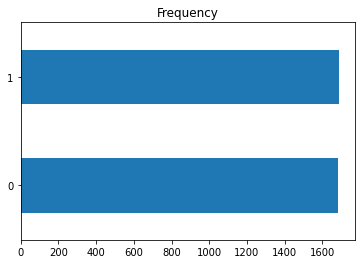

In [ ]:
import matplotlib.pyplot as plt

df_train['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

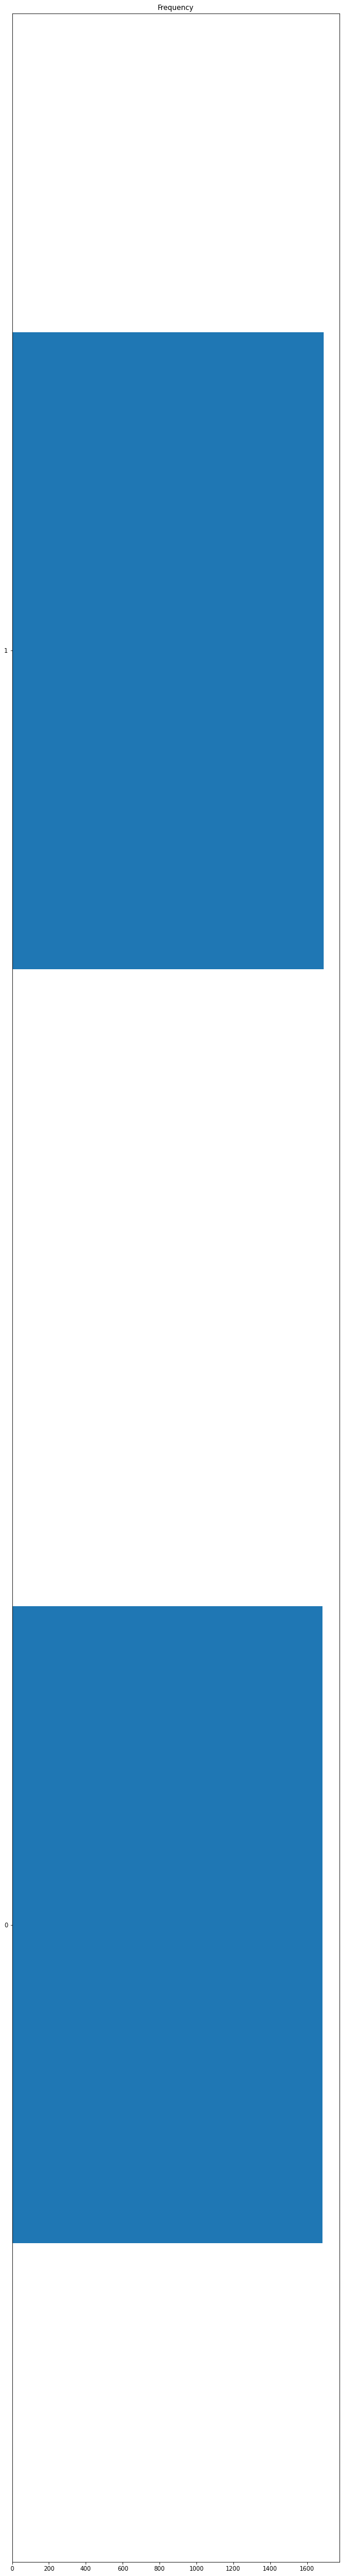

In [ ]:
df_test['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

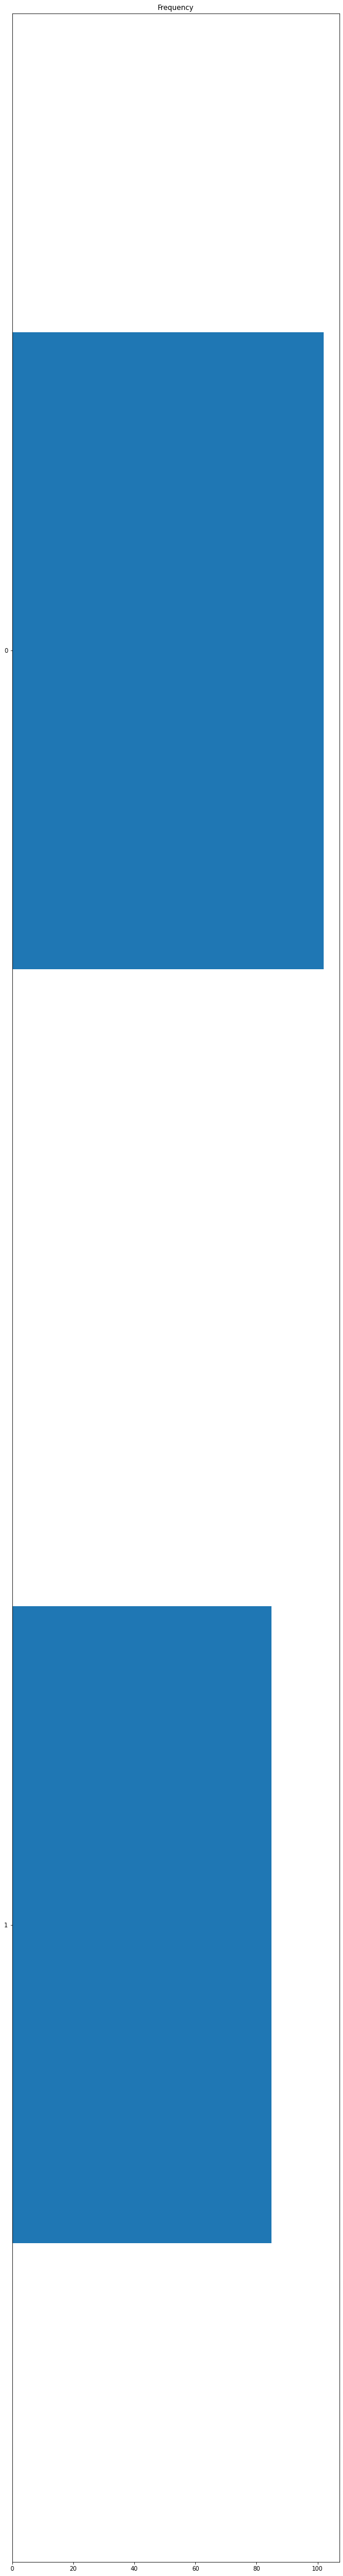

In [ ]:
df_val['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

##Entrenamiento

Para entrenar a nuestro modelo de análisis de sentimientos, primero necesitamos instalar la librería `transformers`

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Tokenizamos los datos con las clases AutoTokenizer y AutoModelForSequenceClassification de la librería transformers. En este caso usamos el modelo [distilbert-base-cased](https://huggingface.co/distilbert-base-cased)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

labels = new_dataset['train'].features['label']

transformer_model = 'distilbert-base-cased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(transformer_model, num_labels = len(labels.names))).to(device)
tokenizer=AutoTokenizer.from_pretrained(transformer_model)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True)

ds_enc = new_dataset.map(tokenize, batched=True)

ds_enc

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3375
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 188
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 187
    })
})

También usamos un data collator para preparar nuestros datos para el entrenamiento y que todos tengan la misma longitud:

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_collator

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

Si ahora vemos el index 0 del subconjunto `train` podemos ver que tenemos el texto de la reseña, su label (0 = negativo) y se han añadido los `input_ids` y los `attention_mask` tras el tokenizado que hicimos previamente

In [ ]:
ds_enc['train'][0]

{'text': 'With the runaway success of "God\'s Army", every Mormon with a camera seems to be trying to make a movie now. In the case of the recent "The Other Side of Heaven", this wasn\'t at all a bad thing. That film, while not great, was quite good. "The Singles Ward", however, is not.<br /><br />Telling the story of a young, divorced Mormon guy thrust back into single life, the writing and shooting style of "The Singles Ward" is, in many ways, very similar to the 80s comedy "Ferris Bueller\'s Day Off". However, the similarities end there. While "Ferris Bueller" was funny, original, and well-acted (as far as stupid comedies like this ever are), "The Singles Ward" is completely the opposite. It tries very hard to be funny. However, 90% of the gags either fall flat or are cliches and jokes you\'ve probably heard a million times before. The other 10% seem to be thrown in to fill out the time. And the acting, while not awful, is amaturish at best.<br /><br />In addition, if you\'re not ei

Definimos las métricas que queremos medir, para que nos arroje tanto resultados de `precisión` como de `recall` y `f1 score`

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

También definimos todos los parámetros necesarios para entrenar al modelo:

In [ ]:
from transformers import TrainingArguments, Trainer

batch_size = 16
model_name = 'finetuned_sentiment_analysis_imbd'
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_enc["train"],
                  eval_dataset=ds_enc["valid"],
                  tokenizer=tokenizer,
                 data_collator=data_collator,)
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.297632,0.898541,0.898396,0.898443
2,No log,0.325231,0.872815,0.866310,0.866563
3,0.326400,0.386891,0.893020,0.893048,0.892931
4,0.326400,0.445168,0.898342,0.898396,0.898343
5,0.086000,0.487287,0.901321,0.898396,0.898600


TrainOutput(global_step=1055, training_loss=0.19735650010583525, metrics={'train_runtime': 829.8102, 'train_samples_per_second': 20.336, 'train_steps_per_second': 1.271, 'total_flos': 2213736176950608.0, 'train_loss': 0.19735650010583525, 'epoch': 5.0})

##Evaluación

Una vez entrenado, podemos obtener las métricas:

In [ ]:
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

{'test_loss': 0.4635140299797058, 'test_precision': 0.8777438906876348, 'test_recall': 0.8776595744680851, 'test_f1': 0.877676893818227, 'test_runtime': 3.1901, 'test_samples_per_second': 58.932, 'test_steps_per_second': 3.762}


Como se puede observar en el siguiente reporte, si consideramos que un buen `f1 score` nos indicaría que tenemos pocos falsos negativos y falsos positivos, y que el de este modelo está en torno a 0.88, tendríamos un muy buen resultado

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = np.array(ds_enc['test']["label"])
y_pred = preds_output.predictions.argmax(-1)

report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
)
print(report)

              precision    recall  f1-score   support

         neg       0.87      0.88      0.87        91
         pos       0.89      0.88      0.88        97

    accuracy                           0.88       188
   macro avg       0.88      0.88      0.88       188
weighted avg       0.88      0.88      0.88       188



##Análisis de emociones (Aprendizaje transferido)

##Preprocesamiento

Para el análisis de emociones, vamos a usar el dataset [Emotion Classification NLP](https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp?select=emotion-labels-val.csv) que contiene una serie de tuits etiquetados con 4 emociones: alegría, tristeza, ira y miedo

In [ ]:
emotion_train = '/content/emotion-labels-train.csv'
emotion_test = '/content/emotion-labels-test.csv'
emotion_val = '/content/emotion-labels-val.csv'

Como en este caso tenemos tres archivos .csv vamos a concatenarlos para tener un solo conjunto de datos:

In [ ]:
import pandas as pd

file_names = [(emotion_train, "train"), (emotion_test, "test"), (emotion_val, "val")]

df_list = []

for file_name, split_name in file_names:
  df = pd.read_csv(file_name, delimiter=",")
  df["split"] = split_name
  df_list.append(df)

df = pd.concat(df_list)
df

,text,label,split
0,Just got back from seeing @GaryDelaney in Burs...,joy,train
1,Oh dear an evening of absolute hilarity I don'...,joy,train
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,train
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,train
4,I feel so blessed to work with the family that...,joy,train
...,...,...,...
342,Common app just randomly logged me out as I wa...,sadness,val
343,"I'd rather laugh with the rarest genius, in be...",sadness,val
344,If you #invest in my new #film I will stop ask...,sadness,val
345,"Just watched Django Unchained, Other people ma...",sadness,val


Nuevamente revisamos si los datos están equilibrados mirando la distribución por la instancia `split` y luego por la instancia label

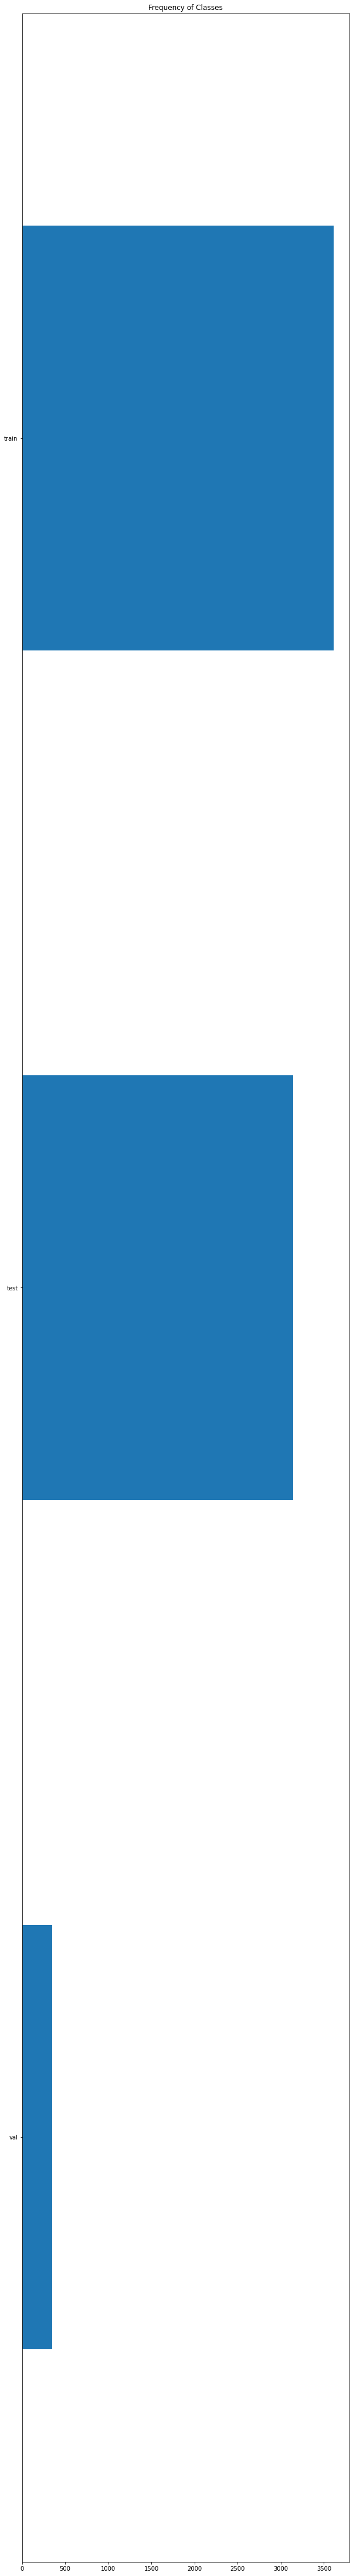

In [ ]:
import matplotlib.pyplot as plt

df["split"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

En este caso vemos que los datos etiquetados con la emoción "fear" tiene un tamaño relativamente mayor que el resto

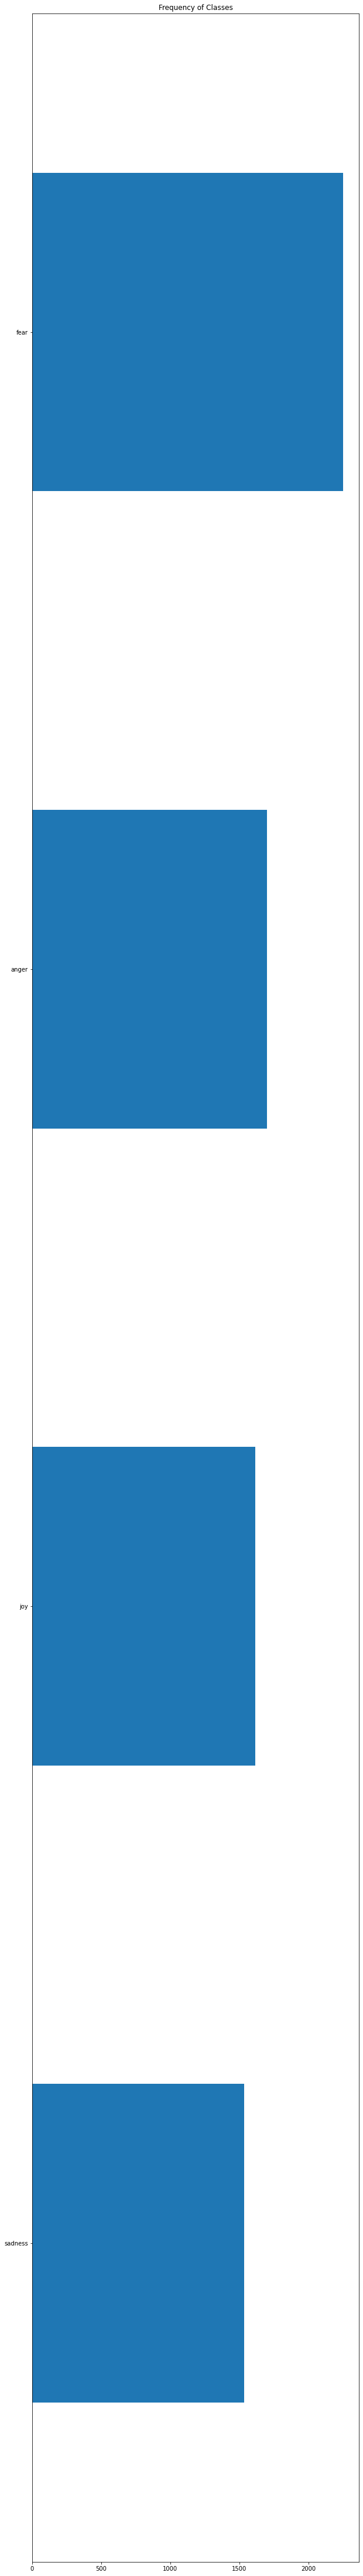

In [ ]:
df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

Este dataset no tiene tantos rows como el anterior, pero aún así para facilitar su procesamiento vamos a reducirlo:

In [ ]:
def select_balanced(df):
  # Agrupa el dataframe por columna y obten tamaño por clase
    grouped = df.groupby('label')
    sizes = grouped.size()
    # Calcula múmero de filas a seleccionar por clase
    selection_size = (sizes * 0.5).apply(int)
    # Selecciona el número específico de filas por clase y concaténalas en un dataframe
    selected_df = pd.concat([group.sample(selection_size[name]) for name, group in grouped])
    return selected_df

Y dividimos el dataset en los tres subconjuntos que necesitamos para trabajar: `train`, `test` y `valid`

In [ ]:
df_train = df[df['split'] == 'train'][['text', 'label']]
df_train = select_balanced(df_train)

df_valid = df[df['split'] == 'val'][['text', 'label']]
df_test = df[df['split'] == 'test'][['text', 'label']]

df_train

,text,label
2120,straight people are canoodling on the quad and...,anger
2645,@JustPyroNow are you gonna do any kind of comm...,anger
2724,Who got madden 17 or 2k17 ps4 add TrackdawgT l...,anger
2751,Colors of the leaves are- changing. Heatwaves...,anger
2496,Chris ate all my mac n cheese so imma eat all ...,anger
...,...,...
3500,@Piggiewhopays lmao! I can only imagine the fr...,sadness
3346,"That's me for the evening, though! Way too lit...",sadness
3441,I wanna see you smile I don't wanna see you ma...,sadness
3507,@pxrfectpeach it's got her little pout,sadness


##Entrenamiento

Nuevamente usaremos la librería `transformers`, y esta vez también la librería `datasets` para convertir este dataset que tenemos en archivos .csv a un dataset de Hugging Face y poder entrenarlo

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Convertimos el dataset a un objeto DatasetDict:

In [ ]:
from datasets import Dataset, DatasetDict

emotion_dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
     "test": Dataset.from_pandas(df_test.reset_index(drop=True))
    }
    )
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1805
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 347
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3142
    })
})

Como la frecuencia de datos etiquetados con la emoción "fear" era relativamente mayor que el resto, calculamos los pesos de clase para poder equilibrar el conjunto train:

In [ ]:
from sklearn.utils import class_weight
import numpy as np
import torch

weights = class_weight.compute_class_weight('balanced', classes=np.unique(emotion_dataset['train']['label']), y=emotion_dataset['train']['label'])
weights = torch.tensor(weights)
weights = weights.to(torch.float32)
weights

tensor([1.0543, 0.7875, 1.0979, 1.1482])

El siguiente paso es para asegurarnos de que creamos la variable `labels` que será la columna de etiquetas de emociones que luego utilizaremos a la hora de tokenizar

In [ ]:
from datasets import ClassLabel

emotion_dataset = emotion_dataset.class_encode_column("label")
labels = emotion_dataset['train'].features['label']
print(labels.names)

Casting to class labels:   0%|          | 0/1805 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/347 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3142 [00:00<?, ? examples/s]

['anger', 'fear', 'joy', 'sadness']


Tokenizamos, esta vez con el modelo [j-hartmann/emotion-english-distilroberta-base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base), que contiene 7 emociones: ira, asco, miedo, alegría, neutral, tristeza y sorpresa

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

transformer_model = 'j-hartmann/emotion-english-distilroberta-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(transformer_model, ignore_mismatched_sizes=True, num_labels = len(labels.names))).to(device)
tokenizer=AutoTokenizer.from_pretrained(transformer_model)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True)

ds_enc = emotion_dataset.map(tokenize, batched=True)

ds_enc

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1805 [00:00<?, ? examples/s]

Map:   0%|          | 0/347 [00:00<?, ? examples/s]

Map:   0%|          | 0/3142 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1805
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 347
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3142
    })
})

Podemos mirar el index 0 en el subconjunto `train` y comprobar que tenemos el `texto`, un `label` (en este caso 0 corresponde a ira), los `input_ids` y los `attention_mask`

In [ ]:
ds_enc['train'][0]

{'text': "straight people are canoodling on the quad and I'm #offended",
 'label': 0,
 'input_ids': [0,
  25868,
  82,
  32,
  64,
  5715,
  1527,
  15,
  5,
  15694,
  8,
  38,
  437,
  849,
  1529,
  6228,
  2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Preparamos las métricas que queremos medir:

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Este bloque es necesario para poder usar los pesos que hemos calculado anteriormente

In [ ]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights).to(device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Definimos los parámetros necesarios y entrenamos al modelo:

In [ ]:
from transformers import TrainingArguments

batch_size = 16
model_name = "finetunned_emotion_NLP_dataset"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

trainer = CustomTrainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_enc["train"],
                  eval_dataset=ds_enc["valid"],
                  tokenizer=tokenizer,
                  data_collator=data_collator,)
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.421865,0.862975,0.861550,0.861318
2,No log,0.400971,0.880020,0.868643,0.873247
3,No log,0.420428,0.890225,0.889918,0.890017
4,No log,0.528262,0.869300,0.859023,0.863157
5,0.332900,0.566103,0.871631,0.862188,0.865884


TrainOutput(global_step=565, training_loss=0.3018015988105166, metrics={'train_runtime': 73.2237, 'train_samples_per_second': 123.252, 'train_steps_per_second': 7.716, 'total_flos': 104005882205064.0, 'train_loss': 0.3018015988105166, 'epoch': 5.0})

##Evaluación

Ahora calculamos las métricas que definimos anteriormente:

In [ ]:
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

{'test_loss': 0.46891501545906067, 'test_precision': 0.8639154071325661, 'test_recall': 0.8635061739660773, 'test_f1': 0.8631528853931325, 'test_runtime': 4.3731, 'test_samples_per_second': 718.484, 'test_steps_per_second': 45.048}


Y de nuevo hacemos un reporte más detallado en el que también obtenemos un `f1 score` bastante bueno (si consideramos que de 0.8 a 0.9 es un buen resultado).

En este caso me preocupaba (o tenía la duda) de si los resultados iban a ser buenos al usar un dataset que solamente estaba etiquetado con 4 emociones, pero luego usar como modelo preentrenado uno que tenía 7 emociones. Entiendo por los resultados que ese hecho no afecta de forma negativa

In [ ]:
from sklearn.metrics import classification_report

y_true = np.array(ds_enc['test']["label"])
y_pred = preds_output.predictions.argmax(-1)

report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0
)
print(report)

              precision    recall  f1-score   support

       anger       0.83      0.88      0.86       760
        fear       0.87      0.85      0.86       995
         joy       0.93      0.87      0.90       714
     sadness       0.82      0.86      0.84       673

    accuracy                           0.86      3142
   macro avg       0.86      0.86      0.86      3142
weighted avg       0.86      0.86      0.86      3142

